# CVGAE

### Input Pre-Processing

In [4]:
import math
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.module import Module

import numpy as np
from scipy.stats import multivariate_normal
from random import randint

import torch_geometric
from torch_geometric.nn import GCNConv


if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f'using {device}')

# Set random seeds for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)  # Set the seed to your desired value

In [5]:
# Antivectorize given vector into adjacency matrix
def antiVectorize(vec, m):
    M = np.zeros((m,m))
    M[np.tril_indices(m,k=-1)] = vec
    M= M.transpose()
    M[np.tril_indices(m,k=-1)] = vec
    return M

# Vectorize graph adjacency matrix into a vector
def vectorize(M):
    return M[np.tril_indices(M.shape[0], k=-1)]

def multivariate_simulate(n_samples=200,n_time=2,n_views=4):
    # Note that changing the node count is not provided right now, since we use correlation matrix
    # and the mean values of connectivities from real data and it is for 35 nodes.
    
    # Import all required statistical information.
    allstats = np.load("./stats/REALDATA_LH_AVGMEANS.npy") # Connectivity mean values of LH. You can also try with RH.
    allcorrs = np.load("./stats/REALDATA_LH_AVGCORRS.npy") # Correlation matrix in LH. You can also try with RH.
    all_diffs = np.load("./stats/REAL_TIME_DIFF.npy") # This is an overall representation of time differences in both (LH and RH) datasets.
    
    times = []
    for t in range(n_time):
        views = []
        for v in range(n_views):
            # Note that we randomly assign a new random state to ensure it will generate a different dataset at each run.
            # Generate data with the correlations and mean values at the current timepoint.
            if t < 2:
                connectomic_means = allstats[t,v]
                data = multivariate_normal.rvs(connectomic_means,allcorrs[t,v],n_samples,random_state=randint(1,9999))
            # If the requested timepoints are more than we have in real data, use the correlation information from the last timepoint.
            else:
                connectomic_means = allstats[-1,v]
                data = multivariate_normal.rvs(connectomic_means,allcorrs[-1,v],n_samples,random_state=randint(1,9999))

            adj = []
            for idx, sample in enumerate(data):
                # Create adjacency matrix.
                matrix = antiVectorize(sample,35)
                # Perturb the real time difference with nonlinear tanh function.
                noise = np.tanh( t / n_time )
                # Further timepoints will have more significant difference from the baseline (t=6 >> t=1).
                matrix = matrix + all_diffs[:,:,v] * ( noise + 1 )
                adj.append(matrix)
            views.append(np.array(adj))

        times.append(np.array(views))
    
    alldata=np.array(times)
    alldata = np.transpose(alldata,(2,0,3,4,1))
    return alldata 

def prepare_data(new_data=False, n_samples=200, n_times=6):
    # Note that data with 200 samples and 6 timepoints is very large (5.8M data points),
    # check your GPU memory to make sure there is enough space to allocate. If not, try:
    # - to reduce dataset size by changing n_samples or n_times.
    # - on CPU (this will allocate memory on RAM) --> This might work for example if you have 1GB GPU memory but 16GB RAM.
    # - on another computer with a better NVIDIA graphics card. --> 2GB GPU memory will not be enough for 5.8M data.
    try:
        if new_data:
            samples = multivariate_simulate(n_samples,n_times)
            np.save('./multivariate_simulation_data.npy',samples)
        else:
            samples = np.load('./multivariate_simulation_data.npy')
    except:
        samples = multivariate_simulate(n_samples,n_times)
        np.save('./multivariate_simulation_data.npy',samples)
    return samples

In [9]:
import numpy
import torch
import torch.nn as nn

def global_normalization(X):
    """
    Perform global normalization on the dataset X.
    
    Parameters:
    X (numpy array): The input data array of shape (num_graphs, num_timepoints, num_nodes, num_nodes, num_domains).
    
    Returns:
    X_normalized (numpy array): The normalized data array with the same shape as X.
    global_mean (float): The global mean of the dataset.
    global_std (float): The global standard deviation of the dataset.
    """
    # Compute the global mean and standard deviation
    global_mean = np.mean(X)
    global_std = np.std(X)
    
    # Normalize the dataset
    X_normalized = (X - global_mean) / global_std
    
    return X_normalized

def preprocess_data(X):
    num_graphs, num_timepoints, num_nodes, _, num_domains = X.shape
    
    subjects = []
    graphs = []
    timepoint_labels = []
    domain_labels = []
    
    for g in range(num_graphs):
        for d in range(num_domains):
            for t in range(num_timepoints):
                graphs.append(X[g, t, :, :, d])
                subjects.append(g)
                domain_labels.append(d)
                timepoint_labels.append(t)

    graphs = np.array(graphs)
    subjects = np.array(subjects)
    timepoint_labels = np.array(timepoint_labels)
    domain_labels = np.array(domain_labels)
    
    return graphs, subjects, timepoint_labels, domain_labels

In [7]:
raw_data = prepare_data(new_data=False, n_samples=100, n_times=3)
# Global normalization
raw_data_normalized = global_normalization(raw_data)

# Pre-process the data
graphs, subjects, timepoint_labels, domain_labels = preprocess_data(raw_data_normalized)
num_timepoints = len(set(timepoint_labels))  
num_domains = len(set(domain_labels))

# # Convert adjacency matrix into vectors
# graph_vector = [vectorize(graph) for graph in graphs]

# Convert data to PyTorch tensors
# graphs_vector_tensor = torch.tensor(graph_vector, dtype=torch.float)
graphs_tensor = torch.tensor(graphs, dtype=torch.float)
subjects_tensor = torch.tensor(subjects, dtype=torch.float)
timepoint_labels_tensor = torch.tensor(timepoint_labels, dtype=torch.long)
domain_labels_tensor = torch.tensor(domain_labels, dtype=torch.long)


In [8]:
from sklearn.model_selection import train_test_split

# Split the data into training, validation, and test sets
unique_subjects = np.unique(subjects)

# First split: Train+Validation and Test (80% Train+Validation, 20% Test)
train_val_subjects, test_subjects = train_test_split(
    unique_subjects, test_size=0.2, random_state=42
)

# # Second split: Train and Validation (80% Train, 20% Validation from Train+Validation set)
# train_subjects, val_subjects = train_test_split(
#     train_val_subjects, test_size=0.25, random_state=42
# )  

def get_subject_indices(subjects, selected_subjects):
    return [i for i, subject in enumerate(subjects) if subject in selected_subjects]


train_indices = get_subject_indices(subjects, train_val_subjects)
# val_indices = get_subject_indices(subjects, val_subjects)
test_indices = get_subject_indices(subjects, test_subjects)

# Create subsets
train_graphs = graphs_tensor[train_indices]
train_timepoint_labels = timepoint_labels_tensor[train_indices]
train_domain_labels = domain_labels_tensor[train_indices]

# val_graphs = graphs_tensor[val_indices]
# val_timepoint_labels = timepoint_labels_tensor[val_indices]
# val_domain_labels = domain_labels_tensor[val_indices]

test_graphs = graphs_tensor[test_indices]
test_timepoint_labels = timepoint_labels_tensor[test_indices]
test_domain_labels = domain_labels_tensor[test_indices]

# Print dataset sizes
print(f'Training set size: {len(train_indices)} graphs')
# print(f'Validation set size: {len(val_indices)} graphs')
print(f'Test set size: {len(test_indices)} graphs')

Training set size: 960 graphs
Test set size: 240 graphs


### Model Definition

In [18]:
class GCN(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super(GCN, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'


class GCNEncoder(nn.Module):
    def __init__(self, input_dim, num_timepoints, num_domains, condition_embedding_dim=7):
        super(GCNEncoder, self).__init__()
        self.num_nodes = input_dim
        self.hidden_dim= 2*input_dim
        self.latent_dim= input_dim
        
        # Embedding layers
        self.timepoint_embedding = nn.Embedding(num_timepoints, condition_embedding_dim)
        self.domain_embedding = nn.Embedding(num_domains, condition_embedding_dim)
    
        # GCN layers
        self.conv1 = GCN(input_dim + condition_embedding_dim*2, self.hidden_dim)
        self.bn1 = nn.BatchNorm1d(self.hidden_dim)
        self.conv2 = GCN(self.hidden_dim, self.latent_dim)
        self.bn2 = nn.BatchNorm1d(self.latent_dim)
        
        self.fc_mu = nn.Linear(self.latent_dim, self.latent_dim)
        self.fc_logvar = nn.Linear(self.latent_dim, self.latent_dim)

    def forward(self, adj, timepoint_label, domain_label):
        # Node features initialization
        num_nodes = self.num_nodes
        x = torch.eye(num_nodes, device=adj.device)
        
        # Conditional features
        timepoint_emb = self.timepoint_embedding(timepoint_label).repeat(x.size(0), 1)
        domain_emb = self.domain_embedding(domain_label).repeat(x.size(0), 1)
        combined_input = torch.cat([x, timepoint_emb, domain_emb], dim=1)
        
        # GCN layers
        x = F.leaky_relu(self.bn1(self.conv1(combined_input, adj)))
        x = F.dropout(x, training=self.training)
        x = F.leaky_relu(self.bn2(self.conv2(x, adj)))
        x = F.dropout(x, training=self.training)
        
        # Node features properties
        x_mean = x.mean(dim=0)
        mu = self.fc_mu(x_mean)
        logvar = self.fc_logvar(x_mean)

        # Reparameterization trick
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        
        if torch.isnan(z).any().item():
            print("there is nan value in encoder input")
        return z, mu, logvar


class GCNDecoder(nn.Module):
    def __init__(self, output_dim, num_timepoints, num_domains, condition_embedding_dim=7):
        super(GCNDecoder, self).__init__()
        self.hidden_dim= 2*output_dim
        self.latent_dim= output_dim

        # Embedding layers
        self.timepoint_embedding = nn.Embedding(num_timepoints, condition_embedding_dim)
        self.domain_embedding = nn.Embedding(num_domains, condition_embedding_dim)
        

        # GCN layers
        self.conv1 = GCN(self.latent_dim + condition_embedding_dim*2, self.hidden_dim)
        self.bn1 = nn.BatchNorm1d(self.hidden_dim)
        self.conv2 = GCN(self.hidden_dim, output_dim)

    def forward(self, z, adj, timepoint_label, domain_label):
        # Conditional features
        timepoint_emb = self.timepoint_embedding(timepoint_label).repeat(z.size(0), 1)
        domain_emb = self.domain_embedding(domain_label).repeat(z.size(0), 1)
        combined_input = torch.cat([z.unsqueeze(0).repeat(z.size(0), 1), timepoint_emb, domain_emb], dim=1)

        # GCN layers
        x = F.leaky_relu(self.bn1(self.conv1(combined_input, adj)))
        x = F.dropout(x, training=self.training)
        x = F.leaky_relu(self.conv2(x, adj))
        x = F.dropout(x, training=self.training)
        
        return x


class ConditionalGraphVAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(ConditionalGraphVAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, adj, timepoint_label, domain_label):
        z, mu, logvar = self.encoder(adj, timepoint_label, domain_label)
        recon_x = self.decoder(z, adj, timepoint_label, domain_label)
        return recon_x, mu, logvar
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [19]:
def loss_function(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kld_loss

### Training

In [20]:
import torch.optim as optim
import matplotlib.pyplot as plt

# Initialize model
encoder = GCNEncoder(input_dim=35, num_timepoints=num_timepoints, num_domains=num_domains)
decoder = GCNDecoder(output_dim=35, num_timepoints=num_timepoints, num_domains=num_domains)
model = ConditionalGraphVAE(encoder, decoder)
print(model)
print(f"Total number of trainable parameters: {model.count_parameters()}")

ConditionalGraphVAE(
  (encoder): GCNEncoder(
    (timepoint_embedding): Embedding(3, 7)
    (domain_embedding): Embedding(4, 7)
    (conv1): GCN (49 -> 70)
    (bn1): BatchNorm1d(70, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): GCN (70 -> 140)
    (bn2): BatchNorm1d(140, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc_mu): Linear(in_features=140, out_features=140, bias=True)
    (fc_logvar): Linear(in_features=140, out_features=140, bias=True)
  )
  (decoder): GCNDecoder(
    (timepoint_embedding): Embedding(3, 7)
    (domain_embedding): Embedding(4, 7)
    (conv1): GCN (154 -> 70)
    (bn1): BatchNorm1d(70, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): GCN (70 -> 35)
  )
)
Total number of trainable parameters: 66913


In [ ]:
import torch.optim as optim

def train_model(model, train_graphs, train_timepoint_labels, train_domain_labels, num_epochs=200, learning_rate=0.001):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    training_loss = []

    def check_for_nan(tensor, name):
        if torch.isnan(tensor).any():
            print(f"NaN values found in {name}")
            return True
        return False

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        
        for i in range(train_graphs.size(0)):
            optimizer.zero_grad()
            
            adj = train_graphs[i]
            timepoint_label = train_timepoint_labels[i]
            domain_label = train_domain_labels[i]
            
            # Forward pass
            recon_x, mu, logvar = model(adj, timepoint_label, domain_label)
            # Compute loss
            loss = loss_function(recon_x, adj, mu, logvar)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()

        epoch_loss /= train_graphs.size(0)
        training_loss.append(epoch_loss)
        
        print(f'Epoch {epoch + 1}, Loss: {epoch_loss}')

    # Plot the training loss
    plt.plot(training_loss)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()

# Example usage:
train_model(model, train_graphs, train_timepoint_labels, train_domain_labels)

### Inference

In [16]:
def inference(model, input_adj, input_timepoint_label, input_domain_label, target_timepoint_label, target_domain_label):
    model.eval()
    with torch.no_grad():
        # Encode the input graph
        z, mu, logvar = model.encoder(input_adj, input_timepoint_label, input_domain_label)
        
        # Decode the latent representation with new conditional information
        recon_adj = model.decoder(z, input_adj, target_timepoint_label, target_domain_label)
    
    return recon_adj

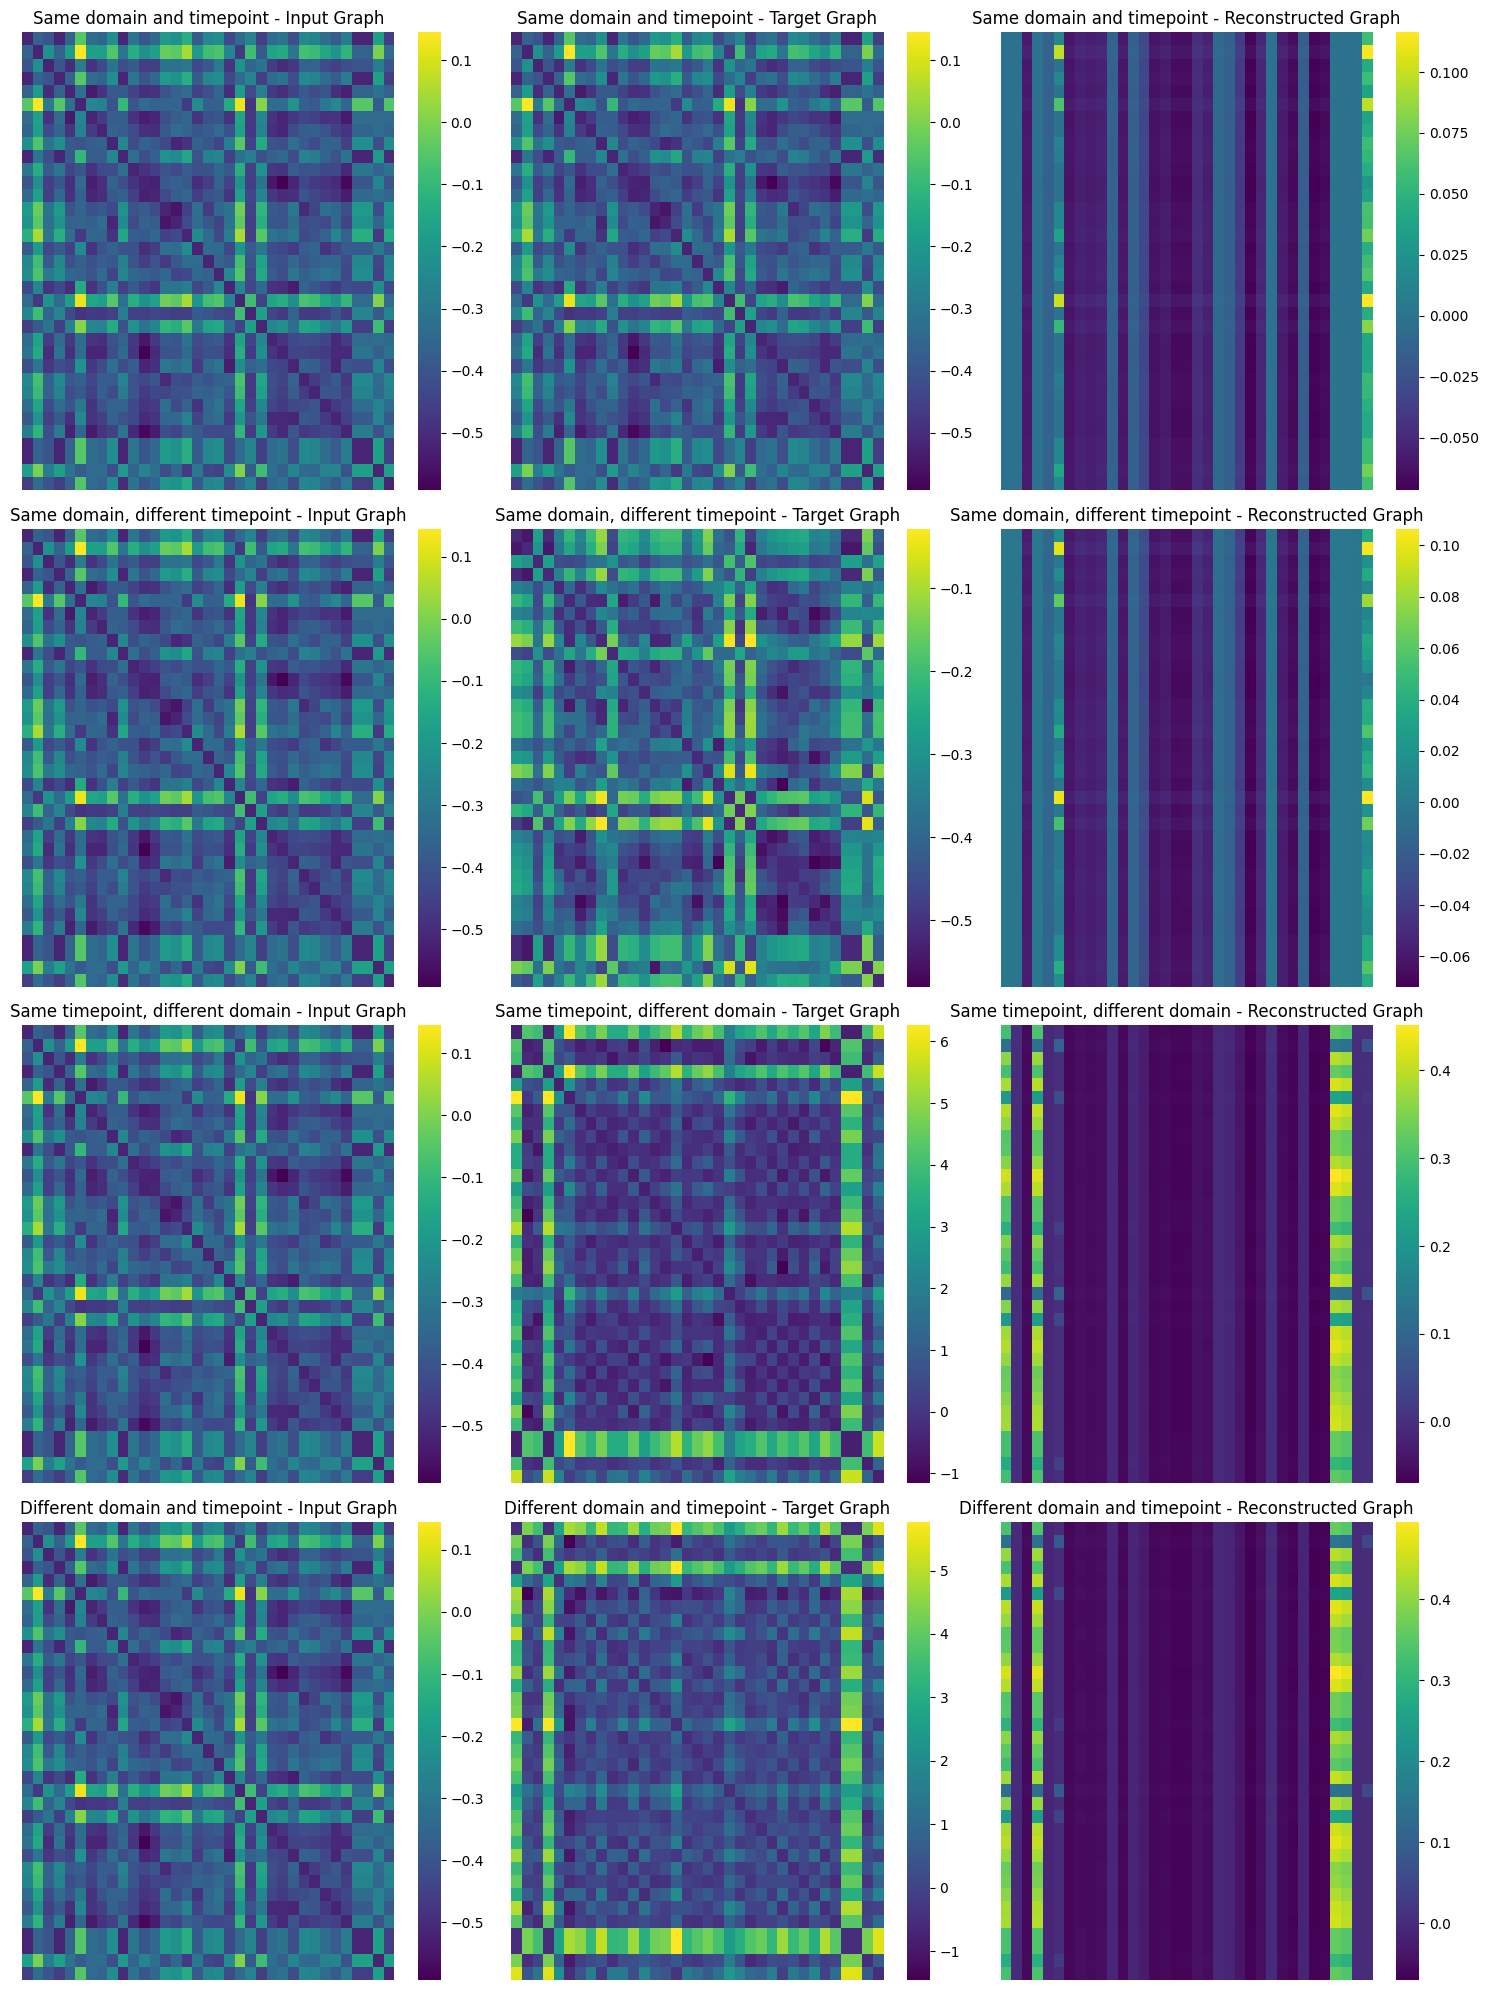

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch

def visualize_heatmaps(model, test_graphs, test_timepoint_labels, test_domain_labels, subject_idx):
    input_graph = test_graphs[subject_idx]
    input_timepoint_label = test_timepoint_labels[subject_idx]
    input_domain_label = test_domain_labels[subject_idx]
    
    fig, axs = plt.subplots(4, 3, figsize=(15, 20))
    
    scenarios = [
        ("Same domain and timepoint", input_timepoint_label, input_domain_label),
        ("Same domain, different timepoint", (input_timepoint_label + 1) % 3, input_domain_label),
        ("Same timepoint, different domain", input_timepoint_label, (input_domain_label + 1) % 4),
        ("Different domain and timepoint", (input_timepoint_label + 1) % 3, (input_domain_label + 1) % 4),
    ]
    
    for i, (title, target_timepoint_label, target_domain_label) in enumerate(scenarios):
        # Inference
        recon_adj = inference(model, input_graph, 
                              input_timepoint_label,
                              input_domain_label, 
                              target_timepoint_label, 
                              target_domain_label).numpy()
        
        target_graph = test_graphs[subject_idx + (target_domain_label - input_domain_label) * 3 + (target_timepoint_label - input_timepoint_label)]
        
        # Plot heatmaps
        sns.heatmap(input_graph, ax=axs[i, 0], cmap='viridis')
        axs[i, 0].set_title(f'{title} - Input Graph')
        axs[i, 0].axis('off')
        
        sns.heatmap(target_graph, ax=axs[i, 1], cmap='viridis')
        axs[i, 1].set_title(f'{title} - Target Graph')
        axs[i, 1].axis('off')
        
        sns.heatmap(recon_adj, ax=axs[i, 2], cmap='viridis')
        axs[i, 2].set_title(f'{title} - Reconstructed Graph')
        axs[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage
subject_idx = 0  # Index of the subject to visualize
visualize_heatmaps(model, test_graphs, test_timepoint_labels, test_domain_labels, subject_idx)


### Evaluation

In [ ]:
from sklearn.metrics import mean_absolute_error

def find_target_graph_idx(target_timepoint_label, target_domain_label, test_timepoint_labels, test_domain_labels):
    for idx in range(0, len(test_timepoint_labels)):  # Step by the number of graphs per subject
        if test_timepoint_labels[idx] == target_timepoint_label and test_domain_labels[idx] == target_domain_label:
            return idx


def evaluate_model(model, test_graphs, test_timepoint_labels, test_domain_labels):
    model.eval()
    mae_same = []
    mae_diff = []

    with torch.no_grad():
        for i in range(len(test_graphs)):
            input_graph = test_graphs[i]
            input_timepoint_label = test_timepoint_labels[i]
            input_domain_label = test_domain_labels[i]

            # Scenario 1: Same domain and timepoint
            recon_adj_same = inference(model, input_graph, input_timepoint_label, input_domain_label, input_timepoint_label, input_domain_label)
            actual_adj_same = input_graph
            mae_same.append(mean_absolute_error(actual_adj_same.numpy().flatten(), recon_adj_same.numpy().flatten()))

            # Scenario 2: Different domain and timepoint combinations
            for target_timepoint_label in range(3):
                for target_domain_label in range(4):
                    if target_timepoint_label == input_timepoint_label and target_domain_label == input_domain_label:
                        continue  # Skip the same domain and timepoint
                    recon_adj_diff = inference(model, input_graph, input_timepoint_label, input_domain_label, 
                                               torch.tensor(target_timepoint_label, dtype=torch.long), 
                                               torch.tensor(target_domain_label, dtype=torch.long))
                    
                    target_idx = find_target_graph_idx(target_timepoint_label, target_domain_label, test_timepoint_labels, test_domain_labels)
                    actual_adj_diff = test_graphs[target_idx]
                    mae_diff.append(mean_absolute_error(actual_adj_diff.numpy().flatten(), recon_adj_diff.numpy().flatten()))

    mae_same_avg = np.mean(mae_same)
    mae_diff_avg = np.mean(mae_diff)

    print(f'MAE (Same domain and timepoint): {mae_same_avg:.2f}')
    print(f'MAE (Different domain and timepoint combinations): {mae_diff_avg:.2f}')

evaluate_model(model, test_graphs, test_timepoint_labels, test_domain_labels)
